## Rice Classification Dataset | VGGG16 | MobileNetV2

![Image Description](https://storage.googleapis.com/kaggle-datasets-images/1440465/2383148/a0e3fd28291e070647f3293db0d12445/dataset-cover.jpg?t=2021-06-30-14-58-16)


## Importing Libraries

In [1]:
import numpy as np  # For numerical operations and array manipulation
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import seaborn as sns  # For statistical data visualization

import cv2  # For image processing and computer vision tasks
import random  # For generating random numbers
import os  # For interacting with the operating system

import keras  # High-level neural networks API
import tensorflow as tf  # Machine learning and deep learning framework
from tqdm import tqdm  # For displaying progress bars
from sklearn.model_selection import train_test_split  # For splitting dataset into training and testing sets
from sklearn.preprocessing import LabelEncoder  # For encoding labels into numerical format
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks for optimizing training process
from tensorflow.keras.applications import *  # Importing pre-trained models for transfer learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img  # For image data augmentation and loading images
from tensorflow.keras.models import Sequential  # For creating sequential model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization  # Different types of neural network layers
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # For evaluating model performance



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading Dataset


This code navigates through a directory of images, categorizing them based on subdirectory names. For each image, it stores the image path in image_paths and the corresponding category label in category_labels, creating two parallel lists for image processing or machine learning applications.

In [2]:
file_path='/kaggle/input/rice-image-dataset/Rice_Image_Dataset'   
        
image_paths = []  # List to store image file paths
category_labels = []  # List to store category labels of images

for category in os.listdir(file_path):
    category_path = os.path.join(file_path, category)  # Full path to the category folder
    if not os.path.isdir(category_path):
        continue  # Skip if it's not a directory

    # Iterate through each image file in the category folder
    for image_file in os.listdir(category_path):
        full_image_path = os.path.join(category_path, image_file)  # Full path to the image file
        image_paths.append(full_image_path)  # Add image path to list
        category_labels.append(category)  # Add category label to list


In [3]:
data = pd.DataFrame({'image':image_paths,'label':category_labels})
data.head()


,image,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


Identifying the classes

In [4]:
class_names = data['label'].unique().tolist()
class_names

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

In [5]:
data.describe()

,image,label
count,75000,75000
unique,75000,5
top,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
freq,1,15000


In [6]:
df_label=data['label'].value_counts().to_frame().reset_index()
df_label

,label,count
0,Karacadag,15000
1,Basmati,15000
2,Jasmine,15000
3,Arborio,15000
4,Ipsala,15000


The data seems to be evenly distributed.
Taking a look at the different classes

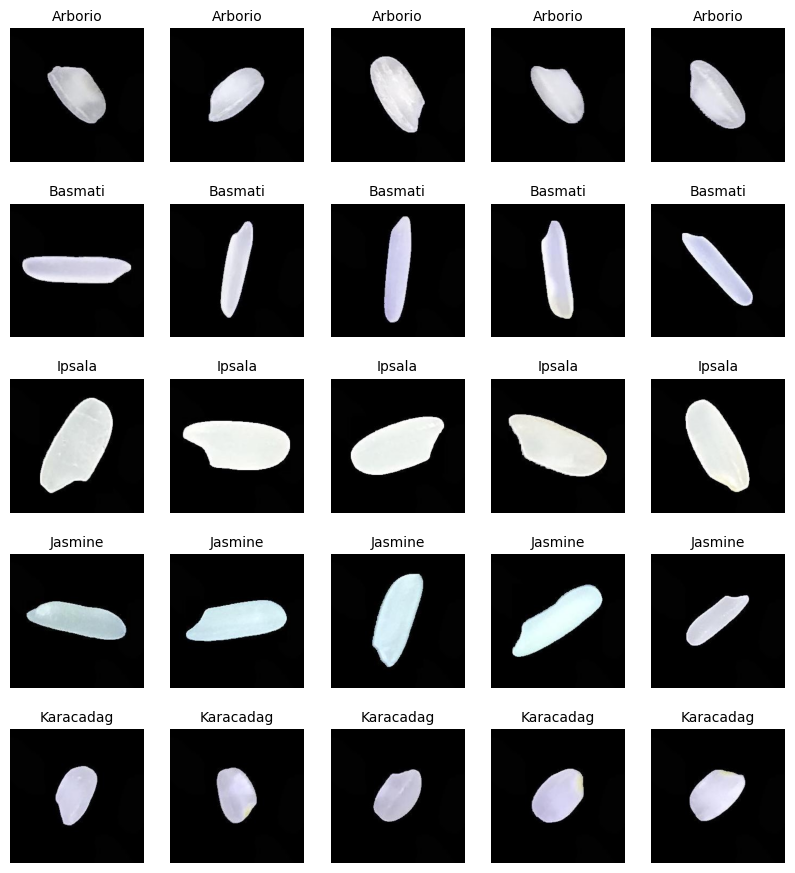

In [7]:
grouped_data=data.groupby('label')
plt.figure(figsize=(10,11))

# Initialize a subplot index
subplot_idx = 1

# Loop through each group (label)
for label, group in grouped_data:
    # Get 5 images from each group
    sample_images = group.sample(n=5, random_state=1)  # Change random_state for different samples

    # Loop through the sample images
    for _, row in sample_images.iterrows():
        img = cv2.imread(row['image'])  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(len(grouped_data), 5, subplot_idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label, fontsize=10)
        subplot_idx += 1

plt.show()

## Spliting the data to feed into the models

In [8]:
x = data['image']
y = data['label']
x_train,x_test1,y_train,y_test1 = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=145)
x_val, x_test, y_val, y_test  = train_test_split(x_test1,y_test1,test_size=0.5,shuffle=True,random_state=145)

In [9]:
print(f'The shape of x_train:{x_train.shape}')
print(f'The shape of x_test:{x_test.shape}')
print(f'The shape of x_val:{x_val.shape}')
print(f'The shape of y_train:{y_train.shape}')
print(f'The shape of y_test:{y_test.shape}')
print(f'The shape of y_val:{y_val.shape}')

The shape of x_train:(60000,)
The shape of x_test:(7500,)
The shape of x_val:(7500,)
The shape of y_train:(60000,)
The shape of y_test:(7500,)
The shape of y_val:(7500,)


In [10]:
train_df = pd.DataFrame({'image':x_train,'label':y_train})
test_df = pd.DataFrame({'image':x_test,'label':y_test})
validation_df = pd.DataFrame({'image':x_val,'label':y_val})

print(f'The shape of train_df:{train_df.shape}')
print(f'The shape of test_df:{test_df.shape}')
print(f'The shape of validation_df:{validation_df.shape}')

The shape of train_df:(60000, 2)
The shape of test_df:(7500, 2)
The shape of validation_df:(7500, 2)


In [11]:
label = LabelEncoder()

y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)
y_val = label.transform(y_val)

In [12]:
Image_size = 60
input_shape = (60,60,3)
Batch_size=32

## Data Augmentation

In [13]:
img_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=90,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.15,  
    zoom_range=0.15  
)


Creating the training, testing and validation generator

In [14]:
train_gen = img_gen.flow_from_dataframe(train_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')

test_gen = img_gen.flow_from_dataframe(test_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=False,class_mode='categorical')

val_gen = img_gen.flow_from_dataframe(validation_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


## Model 1: VGG16 

In [15]:
model_VGG16 =tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(60,60,3),
    weights='imagenet'
)
model_VGG16.trainable = False
input_layer = tf.keras.layers.Input(shape=(60,60,3))
x = model_VGG16(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.15)(x)
output = tf.keras.layers.Dense(5,activation='softmax')(x)

model_VGG16 = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_VGG16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                              

In [16]:
earlystop= EarlyStopping(patience=4)
reduce_lr= ReduceLROnPlateau(monitor="val_accuracy",
                            patience=2,
                            factor=0.5, min_lr=0.00001)
callbacks= [earlystop, reduce_lr]
model_VGG16.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history_modelVGG16 = model_VGG16.fit_generator(train_gen,epochs=10,validation_data=val_gen,callbacks=callbacks)

/tmp/ipykernel_26/2706322897.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_modelVGG16 = model_VGG16.fit_generator(train_gen,epochs=10,validation_data=val_gen,callbacks=callbacks)


Epoch 1/10
1875/1875 [==============================] - 490s 259ms/step - loss: 0.2919 - accuracy: 0.8858 - val_loss: 0.2259 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - 162s 86ms/step - loss: 0.2171 - accuracy: 0.9163 - val_loss: 0.2122 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 3/10
1875/1875 [==============================] - 157s 84ms/step - loss: 0.1970 - accuracy: 0.9255 - val_loss: 0.2297 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 4/10
1875/1875 [==============================] - 159s 85ms/step - loss: 0.1813 - accuracy: 0.9307 - val_loss: 0.2119 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 5/10
1875/1875 [==============================] - 165s 88ms/step - loss: 0.1785 - accuracy: 0.9317 - val_loss: 0.1976 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/10
1875/1875 [==============================] - 159s 85ms/step - loss: 0.1699 - accuracy: 0.9352 - val_loss: 0.1695 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 7/10
1875/1875 [=================

## Model2 : MobileNetV2

In [18]:
model_MobileNetV2 =tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(60,60,3),
    weights='imagenet'
)
model_MobileNetV2.trainable = False
input_layer = tf.keras.layers.Input(shape=(60,60,3))
x = model_MobileNetV2(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(5,activation='softmax')(x)

model_MobileNetV2 = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_MobileNetV2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              5243904   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 5125   

In [19]:
earlystop = EarlyStopping(patience=3)
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         patience=2, verbose=1,
                                         factor=0.5,  min_lr=0.00001)

callbacks = [earlystop,reduce_learning_rate]
model_MobileNetV2.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history_MobileNetV2 = model_MobileNetV2.fit_generator(train_gen,epochs=10,validation_data=val_gen,callbacks=callbacks)

Epoch 1/10


/tmp/ipykernel_26/4171033150.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_MobileNetV2 = model_MobileNetV2.fit_generator(train_gen,epochs=10,validation_data=val_gen,callbacks=callbacks)


1875/1875 [==============================] - 167s 87ms/step - loss: 0.3157 - accuracy: 0.8840 - val_loss: 0.2656 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - 165s 88ms/step - loss: 0.2498 - accuracy: 0.9060 - val_loss: 0.2353 - val_accuracy: 0.9116 - lr: 0.0010
Epoch 3/10
1875/1875 [==============================] - 162s 87ms/step - loss: 0.2411 - accuracy: 0.9096 - val_loss: 0.2068 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 4/10
1875/1875 [==============================] - 160s 85ms/step - loss: 0.2276 - accuracy: 0.9150 - val_loss: 0.2134 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 5/10
1875/1875 [==============================] - 161s 86ms/step - loss: 0.2294 - accuracy: 0.9136 - val_loss: 0.2073 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 6/10
1875/1875 [==============================] - 155s 83ms/step - loss: 0.2197 - accuracy: 0.9186 - val_loss: 0.1877 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 7/10
1875/1875 [=============================

## Evaluation of the two models

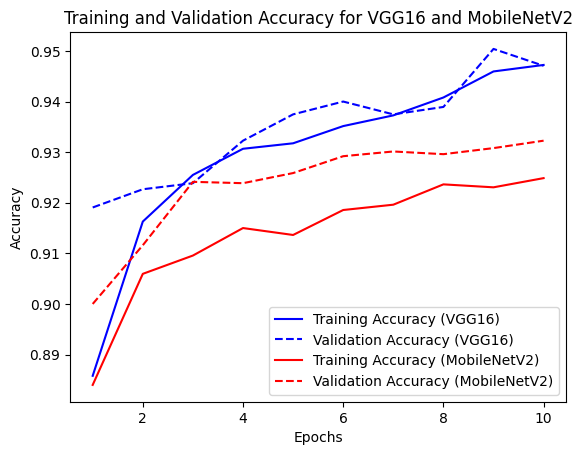

In [21]:
import matplotlib.pyplot as plt

# Extracting accuracy and validation accuracy of the VGG16 model
acc_vgg16 = history_modelVGG16.history['accuracy']
val_acc_vgg16 = history_modelVGG16.history['val_accuracy']

# Extracting accuracy and validation accuracy of the MobileNetV2 model
acc_mobilenetv2 = history_MobileNetV2.history['accuracy']
val_acc_mobilenetv2 = history_MobileNetV2.history['val_accuracy']

# Epochs for each model
epochs_vgg16 = range(1, len(acc_vgg16) + 1)  # VGG16 epochs
epochs_mobilenetv2 = range(1, len(acc_mobilenetv2) + 1)  # MobileNetV2 epochs

# Plotting training and validation accuracy for VGG16
plt.plot(epochs_vgg16, acc_vgg16, 'b-', label='Training Accuracy (VGG16)')
plt.plot(epochs_vgg16, val_acc_vgg16, 'b--', label='Validation Accuracy (VGG16)')

# Plotting training and validation accuracy for MobileNetV2
plt.plot(epochs_mobilenetv2, acc_mobilenetv2, 'r-', label='Training Accuracy (MobileNetV2)')
plt.plot(epochs_mobilenetv2, val_acc_mobilenetv2, 'r--', label='Validation Accuracy (MobileNetV2)')

plt.title('Training and Validation Accuracy for VGG16 and MobileNetV2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


For VGG16, the validation loss decreases and is generally lower than the training loss after the initial epoch, which is a good indicator of the model generalizing well. However, the validation loss shows slight increases at epochs 4, 6, and 7, suggesting minor fluctuations in model performance on the validation set. For MobileNetV2, the validation loss consistently decreases across epochs, indicating steady improvement in model generalization. Despite a slight increase at epoch 10.

MobileNetV2's validation loss at its final epoch is lower than VGG16's, suggesting it may be generalizing slightly better by the end of training. Both models exhibit a typical convergence pattern, with the validation loss tracking closely with the training loss, which suggests that neither model is significantly overfitting. 

Overall, while both models learn effectively, MobileNetV2 shows a more consistent improvement in validation loss,which may indicate a more stable learning process over the epochs. This model can benefir more if the model is run for more number of epochs.

## Prediction VGG16

In [22]:
predictions_VGG16 = model_VGG16.predict(test_gen)
y_pred = np.argmax(predictions_VGG16,axis=1)
y_test =test_gen.classes
df = pd.DataFrame({'Actual':y_test,'predictions_VGG16':y_pred})
df

235/235 [==============================] - 75s 318ms/step


,Actual,predictions_VGG16
0,0,0
1,0,0
2,3,1
3,3,3
4,0,0
...,...,...
7495,3,1
7496,0,0
7497,4,0
7498,0,3


In [23]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1343,    1,    6,   40,   56],
       [   0, 1505,    1,   35,    1],
       [   4,    0, 1529,   22,    0],
       [   3,  109,    7, 1338,    0],
       [  97,    0,    1,    0, 1402]])

In [24]:
classificationReport = classification_report(y_test,y_pred)
print(f'Classification Report : {classificationReport}')

Classification Report :               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1446
           1       0.93      0.98      0.95      1542
           2       0.99      0.98      0.99      1555
           3       0.93      0.92      0.93      1457
           4       0.96      0.93      0.95      1500

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500



## Prediction MobileNetV2

In [25]:
predictions_MobileNetV2 = model_MobileNetV2.predict(test_gen)
y_pred = np.argmax(predictions_MobileNetV2,axis=1)
y_test =test_gen.classes
df = pd.DataFrame({'Actual':y_test,'predictions_MobileNetV2':y_pred})
df

235/235 [==============================] - 18s 72ms/step


,Actual,predictions_MobileNetV2
0,0,4
1,0,0
2,3,3
3,3,3
4,0,0
...,...,...
7495,3,3
7496,0,0
7497,4,4
7498,0,0


In [26]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1283,    0,   21,   33,  109],
       [   0, 1416,    2,  124,    0],
       [   5,    0, 1531,   19,    0],
       [   6,   69,   34, 1348,    0],
       [  96,    0,    2,    2, 1400]])

In [27]:
classificationReport = classification_report(y_test,y_pred)
print(f'Classification Report : {classificationReport}')

Classification Report :               precision    recall  f1-score   support

           0       0.92      0.89      0.90      1446
           1       0.95      0.92      0.94      1542
           2       0.96      0.98      0.97      1555
           3       0.88      0.93      0.90      1457
           4       0.93      0.93      0.93      1500

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500



## The END

Plese suggest ways to improve the model and be a strong critic of the entire notebook.